# RNN ile Havayolu Yolcu Sayısı Tahmini

# 1) Business Problem

RNN yöntemini kullanarak Airline Passengers dataset üzerinden gelecek yıllarda havayolu şirketini kullanabilecek kişi sayısını tahmin etme.

Month: Aylık olarak yer alan tarih değişkenidir.

Passengers: İlgili işlem tarihindeki yolcu sayısını , yani aylık yolcu sayısını temsil etmektedir.

# 2) Data Understanding;

2.1) İmport Libraries

In [1]:

import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2.2) Veri Setinin Yüklenmesi

In [2]:
df = pd.read_csv("/content/international-airline-passengers.csv")

In [3]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:

df.columns = ["Month", "Passengers"]

In [5]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [6]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [7]:
df.shape

(145, 2)

In [8]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [9]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


# 3) Data Preparation

In [11]:
df = df[:144]

In [12]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [14]:
df["Month"] = pd.to_datetime(df["Month"])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [16]:
print("Minimum Tarih:", df["Month"].min())
print("Maksimum Tarih", df["Month"].max())

Minimum Tarih: 1949-01-01 00:00:00
Maksimum Tarih 1960-12-01 00:00:00


In [17]:
df.index = df["Month"]

In [18]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [19]:
df.drop("Month", axis=1, inplace=True)

In [20]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [21]:
result_df = df.copy()

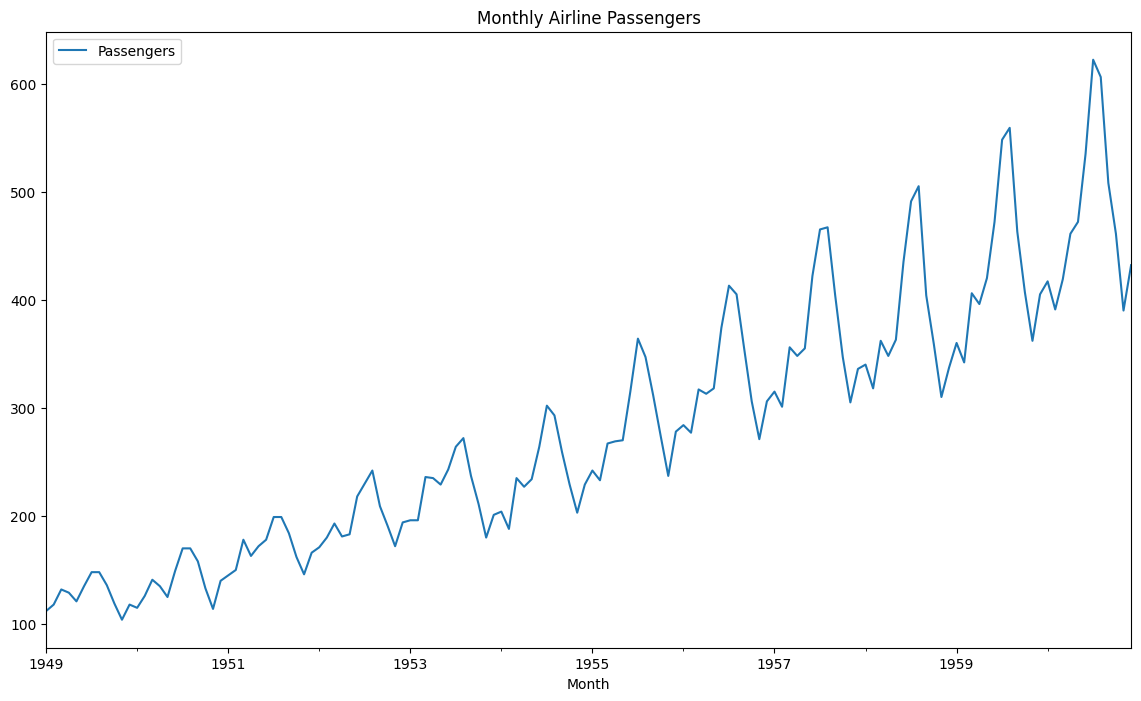

In [22]:
df.plot(figsize=(14, 8), title="Monthly Airline Passengers");

In [23]:
data = df["Passengers"].values

In [24]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [25]:
type(data[0:5])

numpy.ndarray

In [26]:
type(data[0])

numpy.float64

In [27]:
data.shape

(144,)

In [28]:
data = data.reshape(-1, 1)

In [29]:
data.shape

(144, 1)

In [30]:
def split_data(dataframe, test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train, test, position

In [31]:
train, test, position = split_data(data, 0.33)


In [32]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [33]:
scaler_train = MinMaxScaler(feature_range= (0, 1))

In [34]:
train = scaler_train.fit_transform(train)

In [35]:
scaler_test = MinMaxScaler(feature_range= (0, 1))

In [36]:
test = scaler_test.fit_transform(test)

In [37]:
train[0:5]

array([[0.02588997],
       [0.04530744],
       [0.09061489],
       [0.08090615],
       [0.05501618]])

In [38]:
test[0:5]

array([[0.04361371],
       [0.        ],
       [0.17133956],
       [0.14641745],
       [0.1682243 ]])

In [39]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X), np.array(Y)

In [40]:
lookback = 1

In [41]:
# Train veri seti
x_train, y_train = create_features(train, lookback)

In [42]:
# Test veri seti
x_test, y_test = create_features(test, lookback)

In [43]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [44]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [45]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


# 4) Modeling

In [46]:
model = Sequential()

model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(x_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
# Optimizasyon ve Değerlendirme Metrikleri Ayarlanması

model.compile(loss="mean_squared_error", optimizer="adam")

In [48]:
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"),
             ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min",
                             save_best_only=True, save_weights_only= False, verbose=1)]

In [49]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data = (x_test, y_test),
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/50
88/95 [==========================>...] - ETA: 0s - loss: 0.0094
Epoch 1: val_loss improved from inf to 0.03748, saving model to mymodel.h5
95/95 [==============================] - 7s 15ms/step - loss: 0.0107 - val_loss: 0.0375
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 0.0190
Epoch 2: val_loss improved from 0.03748 to 0.02856, saving model to mymodel.h5
95/95 [==============================] - 1s 8ms/step - loss: 0.0190 - val_loss: 0.0286
Epoch 3/50
78/95 [=======================>......] - ETA: 0s - loss: 0.0128
Epoch 3: val_loss improved from 0.02856 to 0.02077, saving model to mymodel.h5
95/95 [==============================] - 0s 5ms/step - loss: 0.0134 - val_loss: 0.0208
Epoch 4/50
87/95 [==========================>...] - ETA: 0s - loss: 0.0077
Epoch 4: val_loss did not improve from 0.02077
95/95 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0224
Epoch 5/50
76/95 [=======================>......] - ETA: 0s - loss: 0.0

Text(0.5, 1.0, 'Training and Validation Loss')

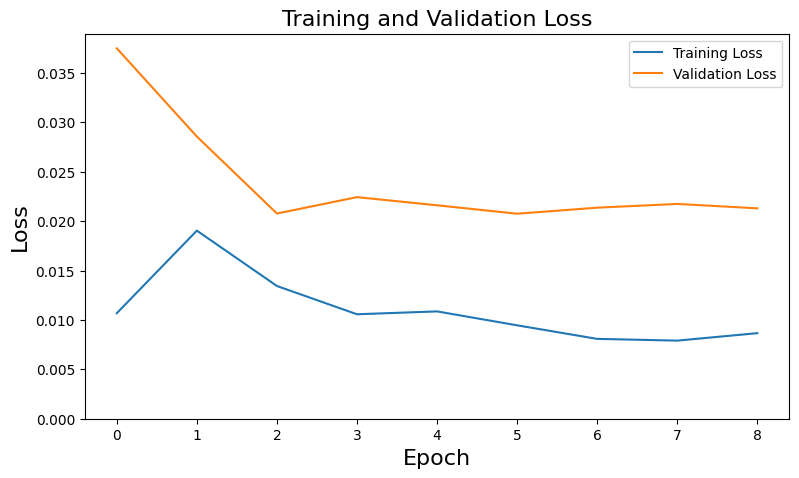

In [50]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)

# 5) Evaluation

In [51]:
loss = model.evaluate(x_test, y_test, batch_size=1)
print("\nTest loss: %.1f%%" % (100.0 * loss))

47/47 [==============================] - 0s 2ms/step - loss: 0.0213

Test loss: 2.1%


In [52]:
train_predict = model.predict(x_train)

3/3 [==============================] - 0s 4ms/step


In [53]:
test_predict = model.predict(x_test)

2/2 [==============================] - 0s 5ms/step


In [54]:
train_predict = scaler_train.inverse_transform(y_train)
test_predict = scaler_test.inverse_transform(y_test)

In [55]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [56]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [57]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 225.84420760147808
Test RMSE: 422.279348351012


In [58]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [60]:
train_prediction_df= result_df[lookback:position]

In [63]:
train_prediction_df["Predicted"] = train_predict

In [64]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,118.0
1949-03-01,132.0,132.0
1949-04-01,129.0,129.0
1949-05-01,121.0,121.0
1949-06-01,135.0,135.0


In [67]:
test_prediction_df= result_df[position + lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,301.0
1957-03-01,356.0,356.0
1957-04-01,348.0,348.0
1957-05-01,355.0,355.0
1957-06-01,422.0,422.0


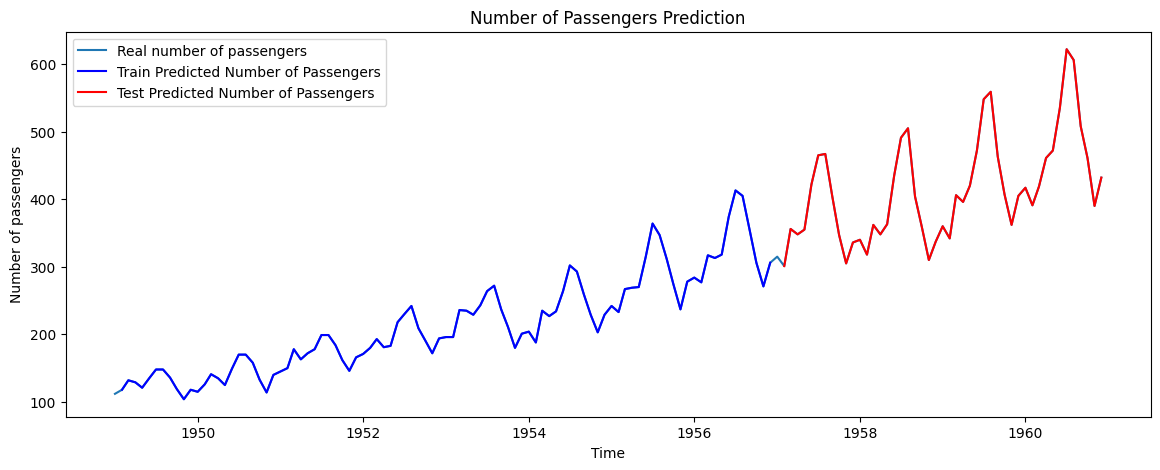

In [70]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(14, 5))
plt.plot(result_df, label="Real number of passengers")
plt.plot(train_prediction_df["Predicted"], color="blue", label="Train Predicted Number of Passengers")
plt.plot(test_prediction_df["Predicted"], color="red", label="Test Predicted Number of Passengers")
plt.title("Number of Passengers Prediction")
plt.xlabel("Time")
plt.ylabel("Number of passengers")
plt.legend()
plt.show()